In [1]:
from os import getcwd
from os.path import join, basename
from sys import path 

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
from libs.simulation_tools import *
from qiskit_aer import AerSimulator
from libs.satellite import *
from new_skr import *

In [2]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# Bob用のリスト
# Location: Sendai
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# Alice用のリスト
# Location: Aizuwakamatsu
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

print(f'zenith_angle_bob_lst: {zenith_angle_bob_lst}')
print(f'zenith_angle_alice_lst: {zenith_angle_alice_lst}')

zenith_angle_bob_lst: [59.12231128 56.36761957 53.29942595 49.86960124 46.02580343 41.71462467
 36.88795594 31.51443373 25.59889386 19.2177631  12.61487602  6.7674352
  6.48171328 12.17404931 18.77234156 25.17778075 31.12682233 36.53619297
 41.39769812 45.74103304 49.61362622 53.06877427 56.15900865 58.93278366
 61.43314946]
zenith_angle_alice_lst: [59.82220731 57.20571    54.31536344 51.11731306 47.5796426  43.67872882
 39.41103877 34.81442487 30.00638313 25.25323752 21.08758441 18.41782064
 18.22698246 20.60210441 24.62188856 29.33180312 34.15113304 38.78495184
 43.10028831 47.05110381 50.63677524 53.87901238 56.80904791 59.46070142
 61.86681358]


In [3]:
num_channel_coefficients = 20000 #100000
array_size = 10**5
num_qubits_per_channel_coefficient = int(1e6)

tau_zen_lst = np.array([0.81, 0.75, 0.55])
# tau_zen_lst = np.array([0.81])

In [4]:
print("a =", a, "m")
print("n_s =", n_s)
print("lambda_signal =", lambda_signal)
print("wavelength =", wavelength, "m")
print("h_OGS =", h_OGS, "m")
print("h_s =", h_s, "m")
print("h_atm =", h_atm, "m")
print("theta_rad =", theta_rad, "radians")
print("v_wind =", v_wind, "m/s")
print("mu_x =", mu_x, "m")
print("mu_y =", mu_y, "m")
print("sigma_theta_x =", sigma_theta_x, "radians")
print("sigma_theta_y =", sigma_theta_y, "radians")
print("e_0 =", e_0)
print("p_dark =", p_dark)
print("e_pol =", e_pol)

a = 0.75 m
n_s = 0.1
lambda_signal = 0.05
wavelength = 8.5e-07 m
h_OGS = 10 m
h_s = 500000 m
h_atm = 20000 m
theta_rad = 5e-06 radians
v_wind = 21 m/s
mu_x = 0 m
mu_y = 0 m
sigma_theta_x = 1.25e-06 radians
sigma_theta_y = 1.25e-06 radians
e_0 = 0.5
p_dark = 1e-05
e_pol = 0.01


In [5]:
backend = AerSimulator()

qber_simul =  np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
average_simulated_sifted_bits = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
skr_values = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))

In [ ]:
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    print(f'tau_zen = {tau_zen}')
    
    for jdx in range(len(zenith_angle_alice_lst)):
        total_sifted_bit_length = 0
        total_err_num = 0
        # 各zenith angleペアに対する累積値を初期化
        print(f'tau_zen = {tau_zen}, zenith_angle_alice = {zenith_angle_alice_lst[jdx]}')
        # アリス（Repeater）のパラメータ
        zenith_angle_alice_deg = zenith_angle_alice_lst[jdx]
        zenith_angle_alice_rad = np.radians(zenith_angle_alice_deg)
        slant_path_alice = slant_path_alice_lst[jdx] # アリスの距離
        sigma_R_squared_alice = rytov_variance(
            wavelength, zenith_angle_alice_rad, h_OGS, h_atm, Cn2_profile)
        w_L_alice = slant_path_alice * theta_rad
        w_Leq_squared_alice = equivalent_beam_width_squared(a, w_L_alice)

        # ボブ（User）のパラメータ
        zenith_angle_bob_deg = zenith_angle_bob_lst[jdx]
        zenith_angle_bob_rad = np.radians(zenith_angle_bob_deg)
        slant_path_bob = slant_path_bob_lst[jdx] # ボブの距離
        sigma_R_squared_bob = rytov_variance(
            wavelength, zenith_angle_bob_rad, h_OGS, h_atm, Cn2_profile)
        w_L_bob = slant_path_bob * theta_rad
        w_Leq_squared_bob = equivalent_beam_width_squared(a, w_L_bob)
        
        
        for kdx in range(int(num_channel_coefficients)):
            # print(f'kdx: {kdx}, tau_zen: {tau_zen}, zenith_angle_alice: {zenith_angle_alice_deg}')
            # --- ステップ1: アリスとボブの瞬時チャネル状態をそれぞれ計算 ---

            # アリス(Repeater)の瞬時透過率
            insta_eta_alice = compute_insta_eta(
                tau_zen, zenith_angle_alice_rad, slant_path_alice,
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                a, w_Leq_squared_alice, theta_rad, sigma_R_squared_alice
            )
            
            # ボブ(User)の瞬時透過率
            insta_eta_bob = compute_insta_eta(
                tau_zen, zenith_angle_bob_rad, slant_path_bob,
                mu_x, mu_y, sigma_theta_x, sigma_theta_y,
                a, w_Leq_squared_bob, theta_rad, sigma_R_squared_bob
            )
   
            
            n_values = np.arange(11)

            # 平均光子数 lambda_signal に基づくポアソン分布から確率を求める
            p_values_raw = [photon_number_probability(n, lambda_signal) for n in n_values[:10]]
            # print(f'p_values_raw: {p_values_raw}')
            p_values = p_values_raw[:]
            p_values.append(1.0 - sum(p_values))  # p_10 を補完

            # 数値安定性のためにクリップ＆正規化
            p_values = np.array(p_values)
            p_values = np.clip(p_values, 0, 1)
            p_values = p_values / np.sum(p_values)
            photon_numbers_array = np.random.choice(n_values, size=array_size, p=p_values)
            count_array = Counter(photon_numbers_array)

            count = [count_array.get(n, 0) for n in n_values]

            # （オプション）検出イベント数の初期化
            n_detect_event = [0] * len(n_values)

            
            num_detected_event = 0
            total_num_detected_event = 0           
            for i in range(len(n_detect_event)):
                if count[i] == 0:
                    continue
            
                yield_val = yield_from_photon_number(i, p_dark, insta_eta_alice, insta_eta_bob)
                for _ in range(count[i]):
                    if np.random.rand() < yield_val:
                        n_detect_event[i] += 1
                
                num_detected_event += n_detect_event[i]
            
            total_num_detected_event += num_detected_event
            # print(f"total_num_detected_event: {total_num_detected_event}")
            if total_num_detected_event == 0:
                # print("Hello World")
                continue
            # print(f"n_detect_event: {n_detect_event}")
            
            for i in range(len(n_detect_event)):
                if n_detect_event[i] > 0:
                    yield_val = yield_from_photon_number(
                        i, 
                        p_dark, 
                        insta_eta_alice, 
                        insta_eta_bob
                    )
                    # print(n_detect_event[i]) 
                    current_bob_qber = pauli_x_application_probability_bob(
                        i,
                        e_0,
                        e_pol,
                        yield_val,
                        insta_eta_alice,
                        insta_eta_bob
                    )
                    current_alice_qber = 0
                    if abs(insta_eta_bob - insta_eta_alice) < 1e-15:
                        if insta_eta_bob == 0: # Both are 0
                            term2 = 0 # (1-(1-0)^(i+1))/(0) -> 0
                        else: # Both are non-zero and equal
                            term2 = (i+1) * (1-insta_eta_alice)**i # L'Hopital's rule limit of (x^k-y^k)/(x-y) as x->y is k*x^(k-1)

                        current_bob_qber = e_0 - ((2*(e_0-e_pol)/((i+1)*yield_val)) * (
                            (1-(1-insta_eta_alice)**(i+1)*(1-insta_eta_bob)**(i+1))/(1-(1-insta_eta_alice)*(1-insta_eta_bob)) - term2
                        ))
                    if total_num_detected_event == 0:
                        print("Hello World")
                        continue
                    if n_detect_event[i] > 5000:
                        continue
                        
                    # print(f"Current Alice QBER: {current_alice_qber}, Current Bob QBER: {current_bob_qber}") 
                    count_sifted, count_error = bbm92simulation(
                            n_detect_event[i],
                            current_alice_qber,
                            current_bob_qber,
                            selected_state_id=3
                    )
                    # part_alice, part_bob, err_num= generate_Siftedkey(
                    #     n_detect_event[i],
                    #     current_alice_qber,
                    #     current_bob_qber,
                    #     backend=backend,
                    # )
                    total_err_num += count_error
                    total_sifted_bit_length += count_sifted
                    # print(f'count_sifted: {count_sifted}, count_error: {count_error}')
        print(f'total_sifted_bit_length: {total_sifted_bit_length}, total_err_num: {total_err_num}')
        # 統計的な平均を計算
        if total_sifted_bit_length > 0:
            avg_qber = total_err_num / total_sifted_bit_length
        else:
            avg_qber = 0.0
        average_simulated_sifted_bits[idx][jdx] = total_sifted_bit_length/(num_channel_coefficients * array_size)
        qber_simul[idx][jdx] = avg_qber
        print(f'Average QBER(%): {avg_qber:.8f} (tau_zen: {tau_zen}, zenith_angle_alice: {zenith_angle_alice_deg})')

tau_zen = 0.81
tau_zen = 0.81, zenith_angle_alice = 59.82220730839252
total_sifted_bit_length: 63949, total_err_num: 3303
Average QBER(%): 0.05165053 (tau_zen: 0.81, zenith_angle_alice: 59.82220730839252)
tau_zen = 0.81, zenith_angle_alice = 57.2057100008884
total_sifted_bit_length: 87337, total_err_num: 4375
Average QBER(%): 0.05009332 (tau_zen: 0.81, zenith_angle_alice: 57.2057100008884)
tau_zen = 0.81, zenith_angle_alice = 54.31536343955395
total_sifted_bit_length: 117661, total_err_num: 6029
Average QBER(%): 0.05124043 (tau_zen: 0.81, zenith_angle_alice: 54.31536343955395)
tau_zen = 0.81, zenith_angle_alice = 51.117313059419615
total_sifted_bit_length: 154277, total_err_num: 7855
Average QBER(%): 0.05091491 (tau_zen: 0.81, zenith_angle_alice: 51.117313059419615)
tau_zen = 0.81, zenith_angle_alice = 47.57964259638222
total_sifted_bit_length: 206019, total_err_num: 10203
Average QBER(%): 0.04952456 (tau_zen: 0.81, zenith_angle_alice: 47.57964259638222)
tau_zen = 0.81, zenith_angle_al

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

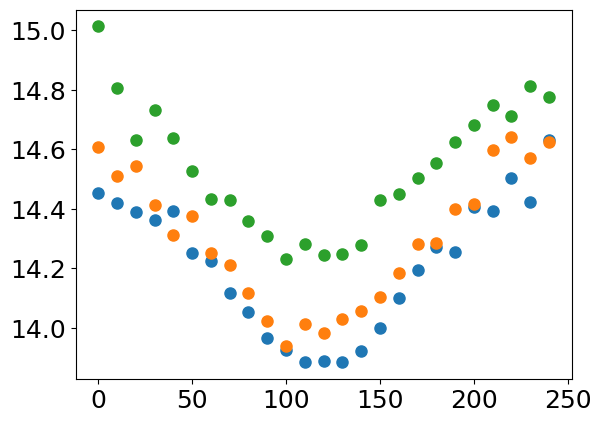

In [28]:
plt.scatter(t, qber_simul[0][:]*100)
plt.scatter(t, qber_simul[1][:]*100)
plt.scatter(t, qber_simul[2][:]*100)

In [ ]:
np.save('results/qber_siml_bbm92_test1_n_s01_the4', qber_simul)
np.save('results/average_simulated_sifted_bits_bbm92_test1_n_s01_the4', average_simulated_sifted_bits)

In [ ]:
# qber_simul = np.load('results/qber_siml_bbm92_test1_n_s05_v2.npy')
# average_simulated_sifted_bits = np.load('results/average_simulated_sifted_bits_bbm92_test1_n_s05.npy')
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        skr_values[idx][jdx] = compute_SKR_BBM92_modified(
            average_simulated_sifted_bits[idx][jdx],
            qber_simul[idx][jdx],
            rep_rate = 1e9,
            kr_efficiency = 1.22
        )
        skr_values[idx][jdx] = skr_values[idx][jdx] / 2

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

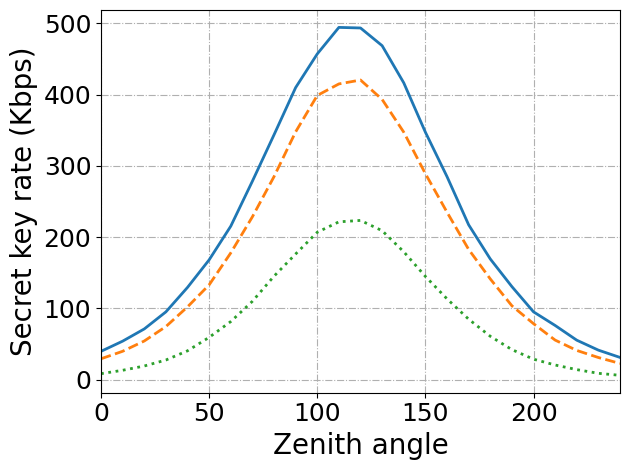

In [38]:
plt.plot(t, skr_values[0][:]/10**3)
plt.plot(t, skr_values[1][:]/10**3, ls='--')
plt.plot(t, skr_values[2][:]/10**3, ls=':')


plt.xlabel(r"Zenith angle")
plt.ylabel(r"Secret key rate (Kbps)")

plt.xlim(0, 240)

plt.grid()
plt.tight_layout()

In [ ]:
np.save('results/skr_siml_bbm92_test1_n_s01_the4', skr_values)

# Test

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

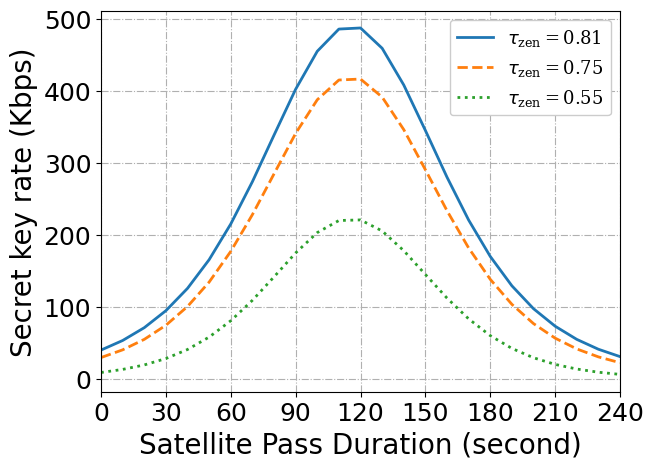

In [45]:
qber_analysis = np.load('results/qber_analysis_bbm92_test1_yudai_n_s05.npy')
average_simulated_sifted_bits = np.load('results/sifted_keyrate_analysis_bbm92_test1_yudai_n_s05.npy')
skr_analysis = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        skr_analysis[idx][jdx] = compute_SKR_BBM92_modified(
            average_simulated_sifted_bits[idx][jdx],
            qber_analysis[idx][jdx],
            rep_rate = 1e9,
            kr_efficiency = 1.22
        )
        skr_analysis[idx][jdx] = skr_analysis[idx][jdx] / 2

plt.plot(t, skr_analysis[0][:]/10**3, label=r'$\tau_{\rm zen} = 0.81$')
plt.plot(t, skr_analysis[1][:]/10**3, ls='--', label=r'$\tau_{\rm zen} = 0.75$')
plt.plot(t, skr_analysis[2][:]/10**3, ls=':', label=r'$\tau_{\rm zen} = 0.55$')

# plt.scatter(t, skr_simul[0][:]/10**3, marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')
# plt.scatter(t, skr_simul[1][:]/10**3, marker='o', c='red', s=30, linewidths=1, zorder=2)
# plt.scatter(t, skr_simul[2][:]/10**3, marker='o', c='red', s=30, linewidths=1, zorder=2)

plt.xlabel(r'Satellite Pass Duration (second)')
plt.ylabel(r"Secret key rate (Kbps)")

plt.xlim(0, 240)

plt.legend()

plt.grid()
plt.tight_layout()
_ = plt.xticks(np.arange(0, 241, 30))
# plt.savefig(f'figure_results/skr_sat_pass_yudai_test2.pdf', format='pdf', bbox_inches="tight")

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

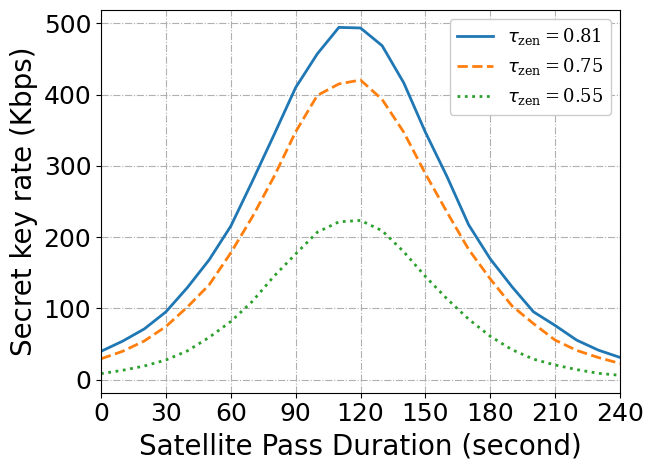

In [44]:
qber_simul = np.load('results/qber_siml_bbm92_test1_n_s05_v2.npy')
sifted_Keyrate = np.load('results/average_simulated_sifted_bits_bbm92_test1_n_s05_v2.npy')
skr_siml = np.zeros((len(tau_zen_lst), len(zenith_angle_alice_lst)))
for idx in range(len(tau_zen_lst)):
    tau_zen = tau_zen_lst[idx]
    for jdx in range(len(zenith_angle_alice_lst)):
        skr_siml[idx][jdx] = compute_SKR_BBM92_modified(
            sifted_Keyrate[idx][jdx],
            qber_simul[idx][jdx],
            rep_rate = 1e9,
            kr_efficiency = 1.22
        )
        skr_siml[idx][jdx] = skr_siml[idx][jdx] / 2

plt.plot(t, skr_siml[0][:]/10**3, label=r'$\tau_{\rm zen} = 0.81$')
plt.plot(t, skr_siml[1][:]/10**3, ls='--', label=r'$\tau_{\rm zen} = 0.75$')
plt.plot(t, skr_siml[2][:]/10**3, ls=':', label=r'$\tau_{\rm zen} = 0.55$')

# plt.scatter(t, skr_simul[0][:]/10**3, marker='o', c='red', s=30, linewidths=1, zorder=2, label='Simulation')
# plt.scatter(t, skr_simul[1][:]/10**3, marker='o', c='red', s=30, linewidths=1, zorder=2)
# plt.scatter(t, skr_simul[2][:]/10**3, marker='o', c='red', s=30, linewidths=1, zorder=2)

plt.xlabel(r'Satellite Pass Duration (second)')
plt.ylabel(r"Secret key rate (Kbps)")

plt.xlim(0, 240)

plt.legend()

plt.grid()
plt.tight_layout()
_ = plt.xticks(np.arange(0, 241, 30))

In [46]:
print(f'SKR Simulation Results: {skr_siml}')
print(f'SKR Analysis Results: {skr_analysis}')

SKR Simulation Results: [[ 39817.10238291  54097.30505932  71226.373646    95171.27845703
  129497.87622979 168147.40602049 215356.79288869 278465.70010549
  343528.68213793 409755.36231626 456984.07192898 494179.60155661
  493374.55503267 468516.28994154 416395.05474032 347210.29624518
  284898.45671997 217311.73139011 169416.22996463 130619.16767298
   95208.75226151  76098.43894792  55454.77145666  41485.80309511
   31260.67412798]
 [ 29385.07462607  39894.9960046   54309.28208352  74562.20614642
  102189.2473815  133056.07859993 177891.32209589 228504.57111766
  284864.99617825 347681.14788204 398712.10643272 414893.7022973
  420361.59915119 393114.13463432 347192.80980284 289021.61779916
  234994.54361462 182773.07478855 141407.71327581 103721.60474653
   78615.70750412  55578.23137148  41077.04268887  31137.14087793
   22799.18410959]
 [  8477.0967728   13242.84848686  19229.80277084  27646.04090448
   40533.28197776  59429.36302657  81589.53739881 109988.13947606
  145217.005714